# Challenge $0$

                                   Erion Islamay, Nicola Zucchia, Vittorio Amoruso, Nicola Cortinovis


### 1. ***Data cleaning with Pandas***

Use the library `pandas` to load and clean the required dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  
import os

Obtain the data file

In [2]:
FFILE = './50_Startups.csv'
if os.path.isfile(FFILE): 
    print("File already exists")
    if os.access(FFILE, os.R_OK):
        print ("File is readable")
    else:
        print ("File is not readable, removing it and downloading again")
        !rm FFILE
        !wget "https://raw.github.com/alexdepremia/ML_IADA_UTs/main/challenge_0/50_Startups.csv"
else:
    print("Either the file is missing or not readable, download it")
    !wget "https://raw.github.com/alexdepremia/ML_IADA_UTs/main/challenge_0/50_Startups.csv"

File already exists
File is readable


In [3]:
# load the dataset using pandas
data = pd.read_csv('50_Startups.csv')
# extract data feature matrix and labels
X = data.iloc[:,:-2].values
y = data.iloc[:,3].values
df = pd.DataFrame(data)

***Play with data***

In [4]:
df.shape

(50, 5)

In [5]:
df.replace(to_replace = 0.00, value = df.mean(axis=0), inplace=True)  # inject the mean of the column when value is 0
df.head() 

C:\Users\Erion\AppData\Local\Temp\ipykernel_23160\1343828299.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.replace(to_replace = 0.00, value = df.mean(axis=0), inplace=True)  # inject the mean of the column when value is 0


,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


***Select two categories for binary classification*** 

In [6]:
df_sel=df[(df.State=="California") | (df.State=="Florida")]
df_sel.head() # column title and first rows of the dataset

,R&D Spend,Administration,Marketing Spend,State,Profit
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
4,142107.34,91391.77,366168.42,Florida,166187.94
6,134615.46,147198.87,127716.82,California,156122.51
7,130298.13,145530.06,323876.68,Florida,155752.60


In [7]:
df_sel.dtypes # type of each column  

R&D Spend          float64
Administration     float64
Marketing Spend    float64
State               object
Profit             float64
dtype: object

***Encode categorical data*** 

One-hot encoding of categorical feature _State_

In [8]:
df_one = pd.get_dummies(df_sel["State"])
df_one.head()

,California,Florida
1,1,0
2,0,1
4,0,1
6,1,0
7,0,1


In [9]:
# construct the final dataset that you will use for learning and prediction
df_fin = pd.concat((df_one, df_sel), axis=1)
df_fin = df_fin.drop(["Florida"], axis=1)
df_fin = df_fin.drop(["State"], axis=1)
# California is class 1, Florida is class 0
df_fin = df_fin.rename(columns={"California": "State"})
df_fin.head()

,State,R&D Spend,Administration,Marketing Spend,Profit
1,1,162597.70,151377.59,443898.53,191792.06
2,0,153441.51,101145.55,407934.54,191050.39
4,0,142107.34,91391.77,366168.42,166187.94
6,1,134615.46,147198.87,127716.82,156122.51
7,0,130298.13,145530.06,323876.68,155752.60


***Normalize***

Divide by the absolute value of the maximum so that features are in \[0, 1\]

In [10]:
def absolute_maximum_scale(series):
    return series / series.abs().max()

for col in df_fin.columns:
    df_fin[col] = absolute_maximum_scale(df_fin[col])
    
df_fin.head()


,State,R&D Spend,Administration,Marketing Spend,Profit
1,1.0,1.000000,0.828805,1.000000,1.000000
2,0.0,0.943688,0.553781,0.918982,0.996133
4,0.0,0.873981,0.500378,0.824892,0.866501
6,1.0,0.827905,0.805926,0.287716,0.814020
7,0.0,0.801353,0.796789,0.729619,0.812091


### ***Classification***

Prepare the dataset:

In [11]:
y = df_fin["State"] # ground truth labels
X = df_fin.drop(["State"], axis=1) # datapoints features
# extract actual values from series 
y = y.values
X = X.values


Train test split

$75\%$ of the data are in the training set, the remaining $25\%$ constitutes the test set.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.25, random_state=0)

Per avere un'intuizione della correlazione tra le variabili, stampiamo al matrice di correlazione.

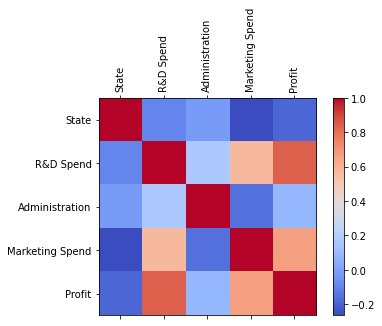

In [13]:
corr = df_fin.corr()
fig = plt.figure()
ax = fig.add_subplot()
cax = ax.matshow(corr, cmap='coolwarm')
fig.colorbar(cax)
ticks = np.arange(0, len(corr.columns), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
plt.xticks(rotation=90)
ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.columns)
plt.show()

Sembra esserci poca correlazione tra la variabile categorica State e le altre variabili. 
Scegliamo di prendere le variabili più correlate e di visualizzare uno scatterplot tra R&S Spend, Administration e State.

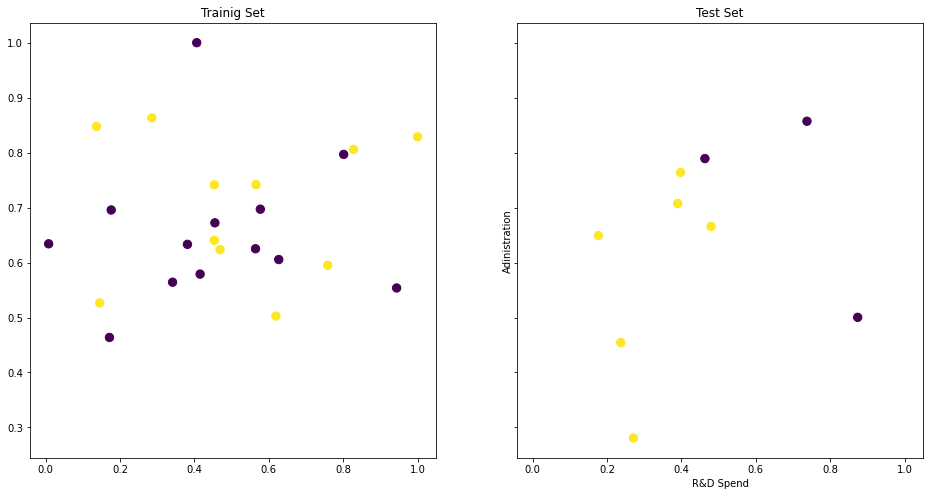

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(16, 8))

# Trainig Set
ax1.scatter(X_train[:,0], X_train[:,1], c=y_train, s=70)
ax1.set_title("Trainig Set")
plt.xlabel("R&D Spend")
plt.ylabel("Adinistration")
plt.title("Training Set")

# Test set
ax2.scatter(X_test[:,0], X_test[:,1], c=y_test, s=70)
ax2.set_title("Test Set")
plt.xlabel("R&D Spend")
plt.ylabel("Adinistration")
plt.title("Test Set")

plt.show()

### Train the Logistic Regression Model

In [15]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=0, solver='lbfgs', penalty='none').fit(X_train, y_train)
y_pred = LR.predict(X_test)
round(LR.score(X_test,y_test), 4)

0.2222

In [16]:
print(y_test,"\n", y_pred)


[1. 1. 1. 0. 0. 1. 1. 1. 0.] 
 [0. 1. 0. 1. 0. 0. 0. 0. 1.]


Visualizzo la differenza tra Ground Truth e i labels predetti.

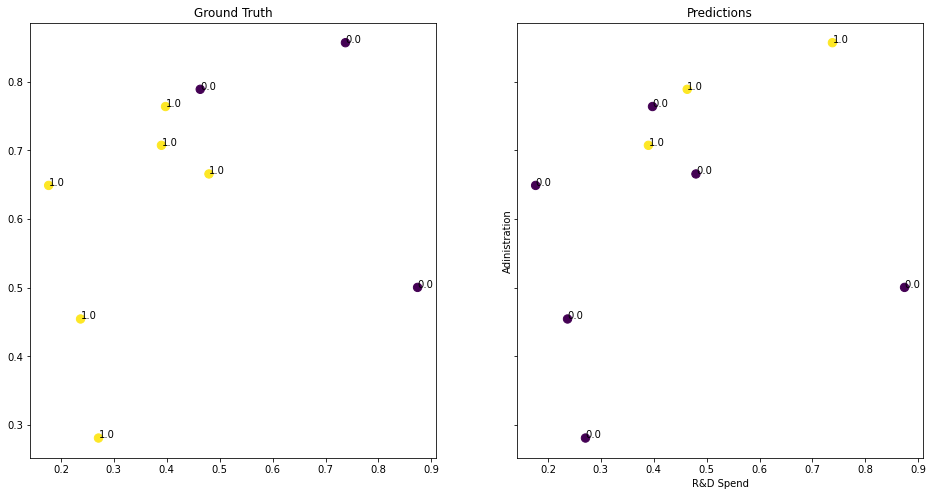

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(16, 8))

ax1.scatter(X_test[:,0], X_test[:,1], c=y_test, s=70)
ax1.set_title("Ground Truth")
plt.xlabel("R&D Spend")
plt.ylabel("Adinistration")
plt.title("Ground Truth")
for i, txt in enumerate(y_test):
    ax1.annotate(txt, (X_test[:,0][i],X_test[:,1][i]))


# Test set
ax2.scatter(X_test[:,0], X_test[:,1], c=y_pred, s=70)
plt.xlabel("R&D Spend")
plt.ylabel("Adinistration")
plt.title("Predictions")
for i, txt in enumerate(y_pred):
    ax2.annotate(txt, (X_test[:,0][i],X_test[:,1][i]))

plt.show()


### ***Plot results***

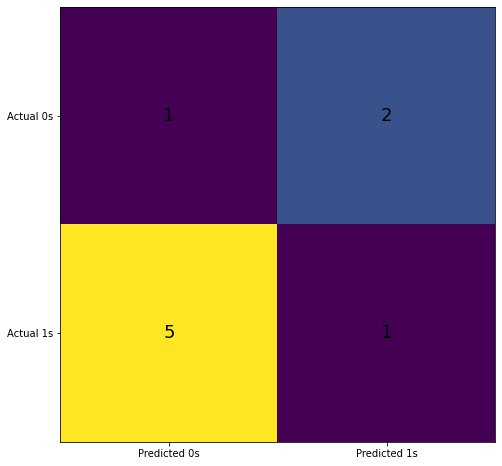

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=18)
plt.show()

In [19]:
target_names = ['California', 'Florida']
print(classification_report(y_test, y_pred, target_names=target_names))


              precision    recall  f1-score   support

  California       0.17      0.33      0.22         3
     Florida       0.33      0.17      0.22         6

    accuracy                           0.22         9
   macro avg       0.25      0.25      0.22         9
weighted avg       0.28      0.22      0.22         9



***Add regularization***

Implement from scratch the regularized logistic regression model (with all the regularization techniques seen during the course). 

###  RIDGE Logistic Regression

In [20]:
import numpy.linalg as LA

def sigmoidM(X, w):
    """
    Parameters
    ----------
    X : array of dim n x d 
        Matrix containing the dataset
    w : array of dim d
        Vector representing the coefficients of the logistic model
    """
    y = 1/(1+np.exp(-np.matmul(X,w)))
    return y

def LogisticLoss(X, y, w):
    """
    Parameters
    ----------
    X : array of dim n x d
        Matrix containing the dataset
    y : array of dim n
        Vector representing the ground truth label of each data point
    w : array of dim d
        Vector representing the coefficients of the logistic model
    """
    points = np.shape(X)[0] # numero di righe in X

    cost = -(1/points)*np.sum(y*np.log(sigmoidM(X,w)) + (1-y)*np.log(1-sigmoidM(X,w)))
    return cost

def LogisticGradient(X,y,w, points):
    return (2/points)*(np.transpose(X)@(sigmoidM(X,w)-y))

Regolarizzazione L2  Ridge

In [21]:
def RidgeLogisticLoss(X, y, w, lam):

    points = np.shape(X)[0] # numero di righe in X
    # ci calcoliamo la loss dalla formula (qui abbiamo scelto di chiamarla cost)
    cost = LogisticLoss(X,y,w) + 1/points*lam*LA.norm(w,2)
    return cost

def RidgeGradient(w, lam):
    return 2*lam*w

def GDRidgeLogistic(X, y, iter, learning_rate, lam):
    """
    Parameters
    ----------
    X : array of float dim n x d
        Matrix containing the dataset
    y : array of float of dim n
        Vector containing the ground truth value of each data point
    iter : int
        Number of GD iterations
    gamma : float
        Learning rate
    points : int
        Number of points in our dataset
    lam : float
        Weight of the L2 penalty term
    """
    d = np.shape(X)
    L = np.zeros(iter)
    #w = np.zeros(d[1])
    w = np.random.uniform(0, 0.01, d[1]) # campioniamo da una uniforme
    W = np.zeros((d[1],iter))
    for i in range(iter):
        W[:,i] = w
        w = w - learning_rate * (LogisticGradient(X,y,w,d[0]) + 1/d[0]*RidgeGradient(w, lam))
        #w = w - (2*gamma/d[0])*((np.transpose(X)@(sigmoidM(X,w)-y)) + RidgeGradient(w, lam))
        L[i] = RidgeLogisticLoss(X,y,w,lam)
    return W, L

L2 Norm of the Difference Between LR Weigths and LR_Ridge Weights:  8.032300632275085


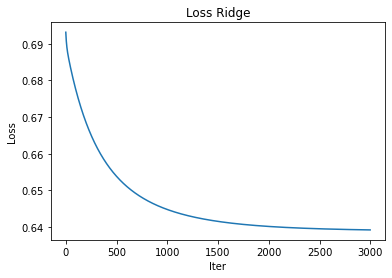

In [22]:
iter = 3000
learning_rate = 0.1
lam = 0.1
w = LR.coef_

wgd_Ridge, Loss_Ridge = GDRidgeLogistic(X_train, y_train, iter, learning_rate, lam)
# ottengo i coefficienti finali perndendo l'ultima riga dell'array wdg_Ridge
wpred_Ridge = wgd_Ridge[:,-1]
# ottengo le labels predette
y_pred_Ridge = sigmoidM(X_test, wpred_Ridge)
y_pred_Ridge = np.where(y_pred_Ridge>0.5,1,0)
# calcolo la differenza in norma2 tra i pesi del modello LR e quelli del modello LR_Ridge
print('L2 Norm of the Difference Between LR Weigths and LR_Ridge Weights: ',
      LA.norm(w-wpred_Ridge,2))

# plot dell'evoluzione della Loss al variare delle iterazioni
plt.plot(Loss_Ridge)
plt.title('Loss Ridge')
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.show()


In [23]:
# classification report         
target_names = ['California', 'Florida']
print(classification_report(y_test, y_pred_Ridge, target_names=target_names))

              precision    recall  f1-score   support

  California       0.20      0.33      0.25         3
     Florida       0.50      0.33      0.40         6

    accuracy                           0.33         9
   macro avg       0.35      0.33      0.33         9
weighted avg       0.40      0.33      0.35         9



implementazione con Sklearn

In [24]:
LR_Ridge_sklearn = LogisticRegression(random_state=0, solver='saga', penalty= "l2").fit(X_train, y_train)
y_pred_Ridge_sklearn = LR_Ridge_sklearn.predict(X_test)
# e poi guardiamo la accuratezza nel testset
print(classification_report(y_test, y_pred_Ridge_sklearn, target_names=target_names))

              precision    recall  f1-score   support

  California       0.33      1.00      0.50         3
     Florida       0.00      0.00      0.00         6

    accuracy                           0.33         9
   macro avg       0.17      0.50      0.25         9
weighted avg       0.11      0.33      0.17         9



c:\Users\Erion\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Erion\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Erion\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### LASSO Logistic Regression

In [25]:
def LassoLogisticLoss(X, y, w, lam):
    """
    Parameters
    ----------
    X : array of float dim n x d
        Matrix containing the dataset
    y : array of float of dim n
        Vector containing the ground truth value of each data point
    w : array of float of dim d
        Weights of the fitted line
    lam : float
        Weight of the L1 penalty term
    """
    points = np.shape(X)[0] # numero di righe in X
    # Loss function
    cost = LogisticLoss(X,y,w) + 1/points*lam*LA.norm(w,1)
    return cost

def L1_subgradient(z): 
    g = np.ones(z.shape)
    g[z < 0.] = -1.0
    return g

def LassoGradient(w, lam):
    return lam * L1_subgradient(w)

def GDLassoLogistic(X, y, iter, learning_rate,lam):
    """
    Parameters
    ----------
    X : array of float dim n x d
        Matrix containing the dataset
    y : array of float of dim n
        Vector containing the ground truth value of each data point
    iter : int
        Number of GD iterations
    gamma : float
        Learning rate
    points : int
        Number of points in our dataset
    d : int
        Dimensionality of each data point in the dataset
    lam : float
        Weight of the L2 penalty term
    """
    d = np.shape(X)
    L = np.zeros(iter)
    #w = np.zeros(d[1])
    w = np.random.uniform(0, 0.01, d[1]) # campioniamo da una uniforme
    W = np.zeros((d[1],iter))
    for i in range(iter):
        W[:,i] = w
        w = w - learning_rate * (LogisticGradient(X,y,w,d[0]) + 1/d[0]*LassoGradient(w, lam))
        L[i] = LassoLogisticLoss(X,y,w,lam)
    return W, L

L2 Norm of the Difference Between LR Weigths and LR_Lasso Weights:  6.184337632389433


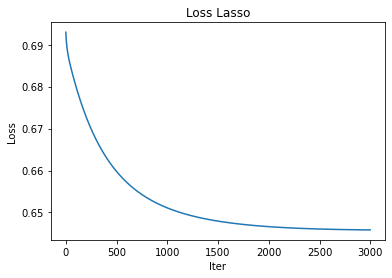

In [26]:
iter = 3000
learning_rate = 0.1
lam = 0.1
w = LR.coef_

wgd_Lasso, Loss_Lasso = GDLassoLogistic(X_train, y_train, iter, learning_rate, lam)
# ottengo i coefficienti finali perndendo l'ultima riga dell'array wdg_Ridge
wpred_Lasso= wgd_Lasso[:,-1]
y_pred_Lasso = sigmoidM(X_test, wpred_Lasso)
y_pred_Lasso = np.where(y_pred_Lasso>0.5,1,0)
# calcolo la differenza in norma2 tra i pesi del modello LR e quelli del modello LR_Ridge
print('L2 Norm of the Difference Between LR Weigths and LR_Lasso Weights: ',
      LA.norm(w-wpred_Lasso,2))


# PRINT
plt.plot(Loss_Lasso)
plt.title('Loss Lasso')
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.show()

In [27]:
print(classification_report(y_test, y_pred_Lasso, target_names=target_names))

              precision    recall  f1-score   support

  California       0.20      0.33      0.25         3
     Florida       0.50      0.33      0.40         6

    accuracy                           0.33         9
   macro avg       0.35      0.33      0.33         9
weighted avg       0.40      0.33      0.35         9



Implementiamo Lasso Regolarization con sklearn

In [28]:
LR_Lasso_sklearn = LogisticRegression(random_state=0, solver ="saga", penalty= 'l1').fit(X_train, y_train)
y_pred_Lasso_sklearn = LR_Lasso_sklearn.predict(X_test)
# e poi guardiamo la accuratezza nel testset
print(classification_report(y_test, y_pred_Lasso_sklearn, target_names=target_names))


              precision    recall  f1-score   support

  California       0.33      1.00      0.50         3
     Florida       0.00      0.00      0.00         6

    accuracy                           0.33         9
   macro avg       0.17      0.50      0.25         9
weighted avg       0.11      0.33      0.17         9



c:\Users\Erion\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Erion\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Erion\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### ElasticNet Logistic Regression

In [29]:
def LogisticLoss(X, y, w):
    """
    Parameters
    ----------
    X : array of dim n x d
        Matrix containing the dataset
    y : array of dim n
        Vector representing the ground truth label of each data point
    w : array of dim d
        Vector representing the coefficients of the logistic model
    """
    n = np.shape(X)[0] # numero di righe in X
    # ci calcoliamo la loss dalla formula (qui abbiamo scelto di chiamarla cost)
    cost = -(1/n)*np.sum(y*np.log(sigmoidM(X,w)) + (1-y)*np.log(1-sigmoidM(X,w)))
    return cost

def LogisticGradient(X,y,w, points):
    return (2/points)*(np.transpose(X)@(sigmoidM(X,w)-y))
    

In [30]:
def ElasticNetSquaredLoss(X, y, w, lr, l, points):
    return LogisticLoss(X, y, w) + 1/points*(lr*l*LA.norm(w, 1) + (1-lr)*l*LA.norm(w, 2))

def ElasticNetGradient(X, y, w, lr, l, points):
    return LogisticGradient(X,y,w,points) + l/points*((1-lr)* RidgeGradient(w, l) + lr*LassoGradient(w, l))

def GDElasticNet(X, y, lr, l, iter, learning_rate):
    points = X.shape[0]
    d = X.shape[1]
    W = np.zeros((d, iter))
    L = np.zeros(iter)
    w = np.random.normal(0, 0.1, d)
    for i in range(iter):
        W[:,i] = w
        w = w - learning_rate * ElasticNetGradient(X, y, w, lr, l, points)
        L[i] = ElasticNetSquaredLoss(X, y, w, lr, l, points)
    return W, L
        

L2 norm of the Differenca Between LR Weigths and LR_ElasticNet Weights:  9.388484195253973


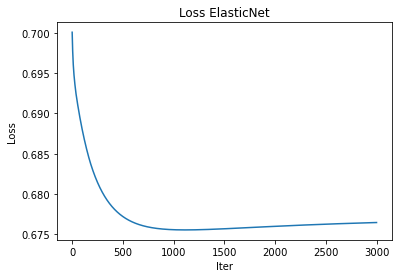

In [31]:
iter = 3000
learning_rate = 0.1
lam = 0.1
lr = 0.5

wgd_ElasticNet, Loss_ElasticNet = GDElasticNet(X, y, lr, lam, iter, learning_rate)
wpred_ElasticNet = wgd_ElasticNet[:,-1]
y_pred_ElasticNet = sigmoidM(X_test, wpred_ElasticNet)
y_pred_ElasticNet = np.where(y_pred_ElasticNet>0.5,1,0)
print('L2 norm of the Differenca Between LR Weigths and LR_ElasticNet Weights: ',
      LA.norm(w-wpred_ElasticNet,2))

# PRINT
plt.plot(Loss_ElasticNet)
plt.title('Loss ElasticNet')
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.show()

In [32]:
print(classification_report(y_test, y_pred_ElasticNet, target_names=target_names))

              precision    recall  f1-score   support

  California       0.20      0.33      0.25         3
     Florida       0.50      0.33      0.40         6

    accuracy                           0.33         9
   macro avg       0.35      0.33      0.33         9
weighted avg       0.40      0.33      0.35         9



Implementiamo ElasticNet con sklearn

In [33]:
LR_ElasticNet_sklearn = LogisticRegression(random_state=0,
                                           solver='saga',
                                           penalty= 'elasticnet',
                                           l1_ratio=0.5).fit(X_train, y_train)
y_pred_ElasticNet_sklearn = LR_ElasticNet_sklearn.predict(X_test)
# e poi guardiamo la accuratezza nel testset
print(classification_report(y_test, y_pred_ElasticNet_sklearn, target_names=target_names))

              precision    recall  f1-score   support

  California       0.33      1.00      0.50         3
     Florida       0.00      0.00      0.00         6

    accuracy                           0.33         9
   macro avg       0.17      0.50      0.25         9
weighted avg       0.11      0.33      0.17         9



c:\Users\Erion\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Erion\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Erion\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### ***ROC curve***

Implement a function for producing the Receiver Operating Characteristic (ROC) curve.

Given true and predicted values, plot the ROC curve using your implemented function.

In [34]:
def find_metrics(y_true, y_pred_prob, threshold):
    """
    Parameters
    ----------
    y_true : array of float containing the Ground Truth
        
    y_pred_prob : Vector containing the predicted probabilities
        t
    threshold : float
    """   
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    # dato il threshold trovo 
    for i in range(len(y_pred_prob)): 
        if(y_pred_prob[i] >= threshold):
            if(y_true[i] == 1):
                tp += 1
            else:
                fp += 1
        elif(y_pred_prob[i] < threshold):
            if(y_true[i] == 0):
                tn += 1
            else:
                fn += 1

            
    tpr = tp/(tp+fn)
    fpr = fp/(tn+fp)

    return [fpr,tpr]

In [35]:
y_pred_prob = LR.predict_proba(X_test)[:,1]
# nel caso in cui la threshold è 0.5
fpr,tpr =find_metrics(y_test,y_pred_prob,0.5)
# stampo la sensitività e specificità
print('Sensitivity: {} ,'.format(round(tpr,2)),'Specificity: {}'.format(round(1-fpr,2)))

Sensitivity: 0.17 , Specificity: 0.33


In [36]:
def create_roc(y_test, y_pred_prob, thresholds):
    roc = np.array([])
    for threshold in thresholds:
        
        fpr,tpr =find_metrics(y_test,y_pred_prob, threshold)
        roc = np.append(roc, [fpr, tpr])
        
    return roc.reshape(-1, 2)

Text(0, 0.5, 'True Positive Rate')

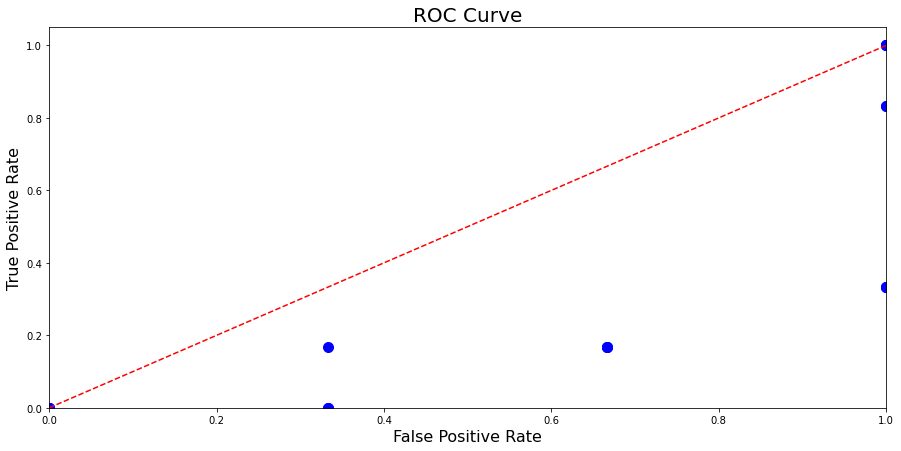

In [37]:
thresholds = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]

ROC = create_roc(y_test, y_pred_prob, thresholds)

plt.figure(figsize=(15,7))
plt.scatter(ROC[:,0],ROC[:,1],color='b',s=100)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC Curve',fontsize=20)
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)



Paragone con sklearn

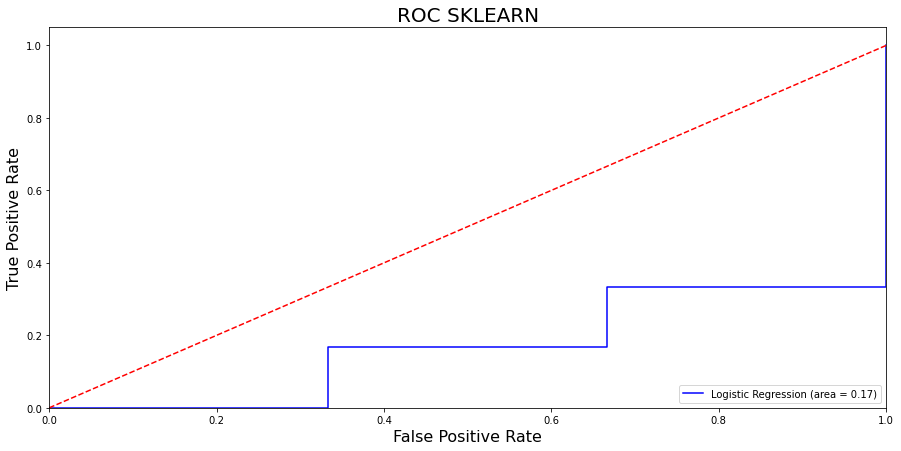

In [38]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr_sklearn, tpr_sklearn, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(15,7))
plt.plot(fpr_sklearn, tpr_sklearn,color='b', label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC SKLEARN', fontsize=20)
plt.legend(loc="lower right")
plt.show()